In [28]:
import pandas as pd
import numpy as np
from datetime import datetime, date, time
import matplotlib.pyplot as plt

In [31]:
mov=pd.read_csv('Data/MovieSummaries/movie.metadata.tsv',sep='\t',header=None)
mov.columns=['wiki_movie_ID','freebase_movie_ID','movie_name','movie_release_date','movie_box_off_rev','movie_runtime','movie_languages','movie_countries','movie_genres']
mov.head()

# mov.to_excel('mov.xlsx', index=False)

,wiki_movie_ID,freebase_movie_ID,movie_name,movie_release_date,movie_box_off_rev,movie_runtime,movie_languages,movie_countries,movie_genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


Let's check how many missing values we have

In [32]:
mov.isnull().sum()

wiki_movie_ID             0
freebase_movie_ID         0
movie_name                0
movie_release_date     6902
movie_box_off_rev     73340
movie_runtime         20450
movie_languages           0
movie_countries           0
movie_genres              0
dtype: int64

In [33]:
len(mov)

81741

In [34]:
print("{:.2%} of the movies have a missing movie box offix revenue value".format(mov.isnull().sum()['movie_box_off_rev']/len(mov)))

89.72% of the movies have a missing movie box offix revenue value


In [35]:
movies_copy = mov
movies_copy.loc[62836, 'movie_release_date'] = '2010-12-02'   #solve a problem of date
movies_copy['movie_release_date'] = movies_copy['movie_release_date'].str[:4]   #only take the year
movies_copy.sort_values(by = 'movie_release_date', ascending = False).head()

,wiki_movie_ID,freebase_movie_ID,movie_name,movie_release_date,movie_box_off_rev,movie_runtime,movie_languages,movie_countries,movie_genres
64862,3139382,/m/08tyfg,Battle Angel,2016,NaN,NaN,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
34022,23124260,/m/064mmw7,Jeepers Creepers 4,2016,NaN,NaN,{},"{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/03npn"": ""Horror""}"
30275,27554912,/m/0c03gcc,Kung Fu Panda 3,2016,NaN,NaN,{},{},{}
51429,25813358,/m/0gmbk1g,Avatar 2,2015,NaN,NaN,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06n90"": ""Science Fiction"", ""/m/02kdv5l"": ..."
8307,24179103,/m/0jwx0kc,"I, Robot 2",2015,NaN,NaN,{},{},"{""/m/06n90"": ""Science Fiction""}"


Are the missing values well distributed over time ?

In [36]:
movies_with_bor = movies_copy[movies_copy.movie_box_off_rev.isnull()==False]
movies_with_bor_gp_year=movies_with_bor.groupby(movies_with_bor['movie_release_date'])[['movie_release_date']].count()
movies_with_bor_gp_year

,movie_release_date
movie_release_date,
1897,1
1914,4
1915,1
1920,1
1921,3
...,...
2008,367
2009,363
2010,329


Text(0.5, 1.0, 'Number of values available per year for the feature "movie_box_off_rev"')

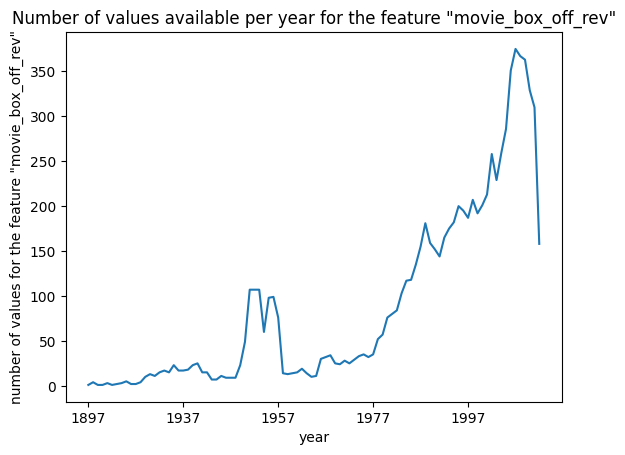

In [49]:
movies_with_bor_gp_year.plot(legend=False)
plt.ylabel('number of values for the feature "movie_box_off_rev"')
plt.xlabel('year')
plt.title('Number of values available per year for the feature "movie_box_off_rev"')

In [43]:
movies_with_bor.sort_values(by = 'movie_release_date', ascending = False).head()

,wiki_movie_ID,freebase_movie_ID,movie_name,movie_release_date,movie_box_off_rev,movie_runtime,movie_languages,movie_countries,movie_genres
49857,28063569,/m/087wc7n,The Lorax,2012,346303939.0,87.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01zhp"": ""Computer Animation"", ""/m/04t36"":..."
28780,30270338,/m/0g54bw9,Joyful Noise,2012,30981384.0,118.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01z4y"": ""Comedy""}"
78929,28882162,/m/0ddbjy4,Dredd,2012,36000000.0,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
56362,33918476,/m/0h1j5fv,Liberal Arts,2012,150210.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/0556j8"": ""..."
78765,24732529,/m/08095xk,Upside Down,2012,5938940.0,NaN,"{""/m/02h40lc"": ""English Language""}","{""/m/0f8l9c"": ""France"", ""/m/0d060g"": ""Canada""}","{""/m/02l7c8"": ""Romance Film"", ""/m/07s9rl0"": ""D..."


We do not have any information after 2012. It seems normal beacuse the paper has been published in 2012

We can see that there are many missing values after 2000 but it could be due to the fact that there are in total more data during this period. The analysis of the ratio of missing values is then more interesting

In [44]:
movie_count_all_gp_year=movies_copy.groupby(movies_copy['movie_release_date'])[['movie_release_date']].count()
movie_count_all_gp_year['ratio_bor']=movies_with_bor_gp_year['movie_release_date']/movie_count_all_gp_year['movie_release_date']

Text(0.5, 1.0, 'Ratio of values available per year for the feature "movie_box_off_rev"')

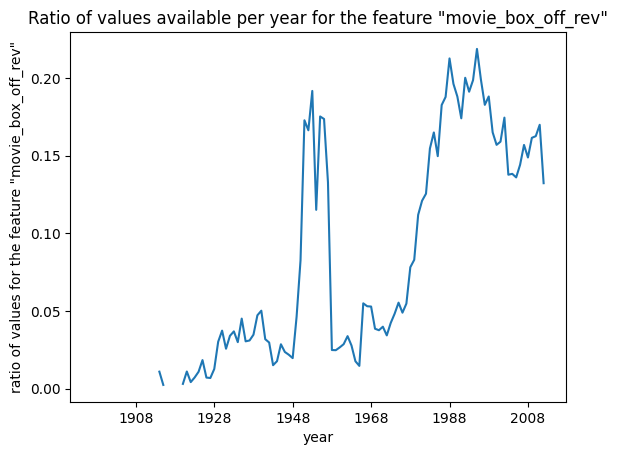

In [48]:
movie_count_all_gp_year['ratio_bor'].plot(legend=False)
plt.ylabel('ratio of values for the feature "movie_box_off_rev"')
plt.xlabel('year')
plt.title('Ratio of values available per year for the feature "movie_box_off_rev"')

Let's check the evolution of the average revenue of box offices through time

In [51]:
movies_mean_bor_gp_year=movies_with_bor.groupby(movies_with_bor['movie_release_date'])[['movie_box_off_rev']].mean()
movies_mean_bor_gp_year

,movie_box_off_rev
movie_release_date,
1897,1.000000e+05
1914,7.079320e+05
1915,5.000000e+07
1920,4.500000e+06
1921,2.633333e+06
...,...
2008,6.071359e+07
2009,6.835295e+07
2010,6.990730e+07


Text(0.5, 1.0, 'Evolution of the average box office revenue')

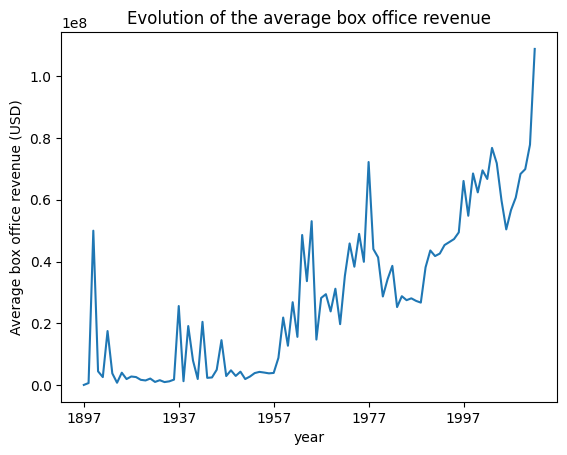

In [54]:
movies_mean_bor_gp_year.plot(legend=False)
plt.ylabel('Average box office revenue (USD)')
plt.xlabel('year')
plt.title('Evolution of the average box office revenue')

In [ ]:
char=pd.read_csv('Data/MovieSummaries/character.metadata.tsv',sep='\t',header=None)
char.columns=['wiki_movie_ID','freebase_movie_ID','movie_release_date','character_name','actor_DOB','actor_gender','actor_height','actor_ethnicity','actor_name','actor_age_movie','freebase_char/actor_map_ID','freebase_char_ID','freebase_actor_ID']
char.head()

# char.movie_release_date.apply(lambda d: datetime.strptime(d, '%y-%m-%d')).head(10)

In [16]:
name_clusters=pd.read_table('Data/MovieSummaries/name.clusters.txt',header=None)#,sep=" ",header=None)
name_clusters.columns=['character_name','freebase_char/actor_map_ID']
name_clusters.head()

,character_name,freebase_char/actor_map_ID
0,Stuart Little,/m/0k3w9c
1,Stuart Little,/m/0k3wcx
2,Stuart Little,/m/0k3wbn
3,John Doe,/m/0jyg35
4,John Doe,/m/0k2_zn


In [12]:
plot_summaries=pd.read_table('Data/MovieSummaries/plot_summaries.txt',header=None)
plot_summaries.columns=['wiki_movie_ID','movie_plot']
plot_summaries.head()

,wiki_movie_ID,movie_plot
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


In [13]:
type_char=pd.read_table('Data/MovieSummaries/tvtropes.clusters.txt',header=None)
type_char.columns=['char_type','infos']
type_char.head()

,char_type,infos
0,absent_minded_professor,"{""char"": ""Professor Philip Brainard"", ""movie"":..."
1,absent_minded_professor,"{""char"": ""Professor Keenbean"", ""movie"": ""Richi..."
2,absent_minded_professor,"{""char"": ""Dr. Reinhardt Lane"", ""movie"": ""The S..."
3,absent_minded_professor,"{""char"": ""Dr. Harold Medford"", ""movie"": ""Them!..."
4,absent_minded_professor,"{""char"": ""Daniel Jackson"", ""movie"": ""Stargate""..."


In [14]:
import json
list=[]

for i in range(len(type_char)):
    list=list+[json.loads(type_char['infos'][i])]

char_type_df=pd.DataFrame(list)

char_type_df

,char,movie,id,actor
0,Professor Philip Brainard,Flubber,/m/0jy9q0,Robin Williams
1,Professor Keenbean,Richie Rich,/m/02vchl3,Michael McShane
2,Dr. Reinhardt Lane,The Shadow,/m/0k6fkc,Ian McKellen
3,Dr. Harold Medford,Them!,/m/0k6_br,Edmund Gwenn
4,Daniel Jackson,Stargate,/m/0k3rhh,James Spader
...,...,...,...,...
496,Morgan Earp,Tombstone,/m/0k776f,Bill Paxton
497,Colorado Ryan,Rio Bravo,/m/0k2kqg,Ricky Nelson
498,Tom Sawyer,The League of Extraordinary Gentlemen,/m/0k5nsh,Shane West
499,William H. 'Billy the Kid' Bonney,Young Guns II,/m/03lrjk0,Emilio Estevez


In [15]:
char_type_df['char_type']=type_char['char_type']
char_type_df.columns=['character_name','movie_name','freebase_char/actor_map_ID','actor_name','char_type']
char_type_df

,character_name,movie_name,freebase_char/actor_map_ID,actor_name,char_type
0,Professor Philip Brainard,Flubber,/m/0jy9q0,Robin Williams,absent_minded_professor
1,Professor Keenbean,Richie Rich,/m/02vchl3,Michael McShane,absent_minded_professor
2,Dr. Reinhardt Lane,The Shadow,/m/0k6fkc,Ian McKellen,absent_minded_professor
3,Dr. Harold Medford,Them!,/m/0k6_br,Edmund Gwenn,absent_minded_professor
4,Daniel Jackson,Stargate,/m/0k3rhh,James Spader,absent_minded_professor
...,...,...,...,...,...
496,Morgan Earp,Tombstone,/m/0k776f,Bill Paxton,young_gun
497,Colorado Ryan,Rio Bravo,/m/0k2kqg,Ricky Nelson,young_gun
498,Tom Sawyer,The League of Extraordinary Gentlemen,/m/0k5nsh,Shane West,young_gun
499,William H. 'Billy the Kid' Bonney,Young Guns II,/m/03lrjk0,Emilio Estevez,young_gun
